In [1]:
import sys
import numpy as np
import pandas as pd
from fortran import fortran
from scipy.constants import pi, Boltzmann as kb
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# ===================== DEFINING PARAMETERS =====================

n = 1000                # Number of nanoparticles
mcs = 40                # Monte Carlo steps
dThet = 20              # Solid angle for transitions
dThet = dThet*pi/180.0
temp = 100              # Temperature in Kelvin
Hmax = 1                # Magnetic Field (Tesla)
nHstep = 200            # Number of steps for the field
kuni = 4.7e5            # Uniaxial anisotropy constant in J/m³
Ms = 1400e3             # Saturation magnetization in A/m
d = 5e-9                # Diameter of the nanoparticles in m

In [3]:
# ===================== DECLARING ARRAYS =====================

mag = np.empty(shape=(int(n),3))
ku = np.empty(shape=(int(n),3))
xyz = np.empty(shape=(int(n),3))
vecH = np.empty(shape=(1,3))
hextStg = np.empty(shape=(3,3))
mhCurve = np.empty(shape=(int(n),2))
H = np.empty(shape=(1,3))

In [4]:
# ===================== DECLARING FORTRAN SUBROUTINES =====================  

abc = fortran.subr1           # Metropolis algorithm
HextCalc = fortran.subr2      # Setting hex value
randomArrays = fortran.subr3  # Create de position, mag and ku arrays at random (Initial configuration)
magTotalSet = fortran.subr4   # Calculating total magnetic field

In [5]:
# ===================== INITIAL CONFIGURATION =====================  

mag, ku, xyz = randomArrays(pi,n)
magInit = mag
# FILLIN FILES magData.txt and xyzData.txt
with open("magData.txt","wb") as file:
    np.savetxt(file,mag,delimiter="\t")
with open("xyzData.txt","wb") as file:
    np.savetxt(file,xyz,delimiter="\t")    
# ERASING TRASH DATA IN mhData.txt, this is the M(H) curve data to be plotted
with open("mhData.txt", "w"):
    pass

In [6]:
dfMag = pd.DataFrame(data=mag[0:,0:],columns=['x','y','z']) # CREATE DATAFRAME FOR ARRAY
dfXyz = pd.DataFrame(data=xyz[0:,0:],columns=['x','y','z']) 

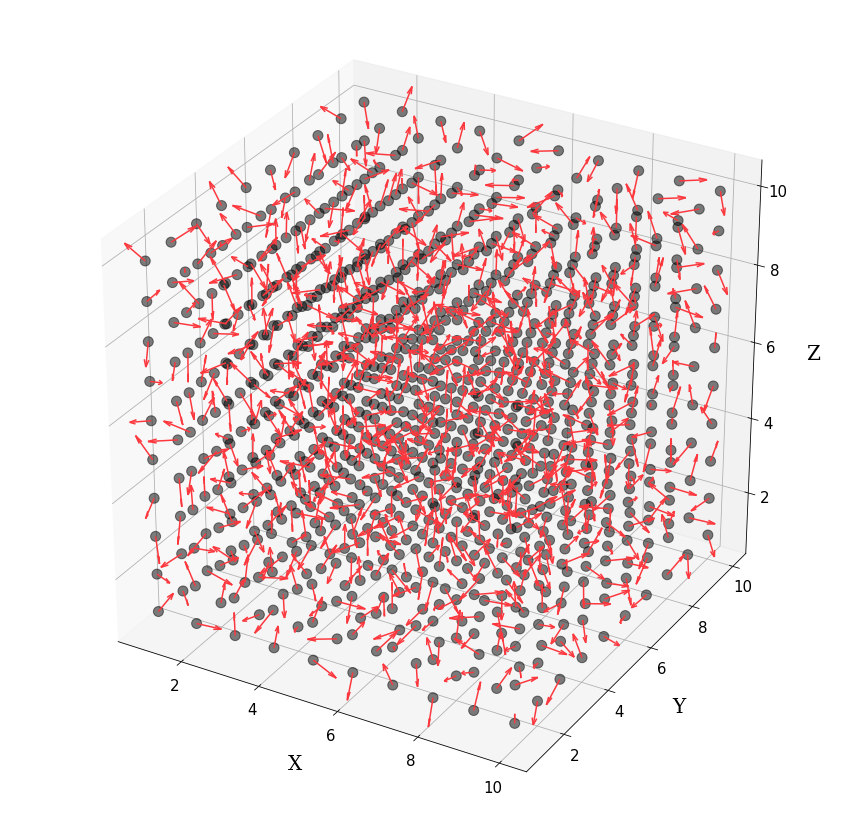

In [7]:
# ============= PLOTTING INITIAL CONFIGURATION =============
#Normal 3D plot
%matplotlib inline 
#Interactive 3D plot
#%matplotlib qt 

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfXyz.x, dfXyz.y, dfXyz.z, s=100, alpha=0.5, color="k")
ax.quiver(dfXyz.x, dfXyz.y, dfXyz.z,dfMag.x, dfMag.y, dfMag.z, length=0.65, color='#FC383E')
#ax.set_title('3D - Representation', size="xx-large", family="serif", weight= "semibold")
ax.set_xlabel('X',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.set_ylabel('Y',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.set_zlabel('Z',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.tick_params(labelsize=15)
plt.savefig('3d.svg')
plt.show()

In [8]:
# INITIALIZING VARIABLES
vecH = np.array([0.0,0.0,1.0]) # FIELD DIRECTION
nHext = int(5*nHstep/2-2)
Hext = 0.0
magTotal = 0.0

In [9]:
# SETTING magTotal
magTotal = magTotalSet(mag, vecH,n)

In [10]:
# FILLING DATAFRAME AND ARRAY
df = pd.DataFrame([
    [Hext, magTotal]
], columns = ["Hext", "MagTotal"])
H[0] = Hext*vecH
# FILLING FILE Hvector.txt
with open("Hvector.txt","wb") as file:
    np.savetxt(file,H,delimiter="\t") 

In [11]:
# SETTING magTotal AND DATAFRAME USING MARKOV CHAINS
for i in range(0,nHext):    
    Hext = HextCalc(Hext,nHstep,Hmax,i)    
    H[0] = np.multiply(vecH,Hext)
    # FILLING FILE Hvector.txt
    with open("Hvector.txt","wb") as file:
        np.savetxt(file,H,delimiter="\t") 
        
    for step in range(0,int(mcs)):
        for nanoparticle in range(0,int(n)):
            randN = round(np.random.rand()*(n-1)) #Random Nanoparticle
            mag[randN] = abc(vecH, Hext, dThet, ku[randN], pi, mag[randN], d, kuni, Ms, kb, temp)  #THIS IS THE VALUE THAT I WANT TO PLOT DYNAMICALLY           
                       
    # FILLING FILE magData.txt
    with open("magData.txt","wb") as file:
        np.savetxt(file,mag,delimiter="\t")      
                
    magTotal = magTotalSet(mag, vecH,n)   
    print(i,Hext,magTotal)
    df.loc[i+1]=[Hext,magTotal]
    # FILLING FILE mhData.txt
    mhCurve[i+1,0] = Hext
    mhCurve[i+1,1] = magTotal
    with open('mhData.txt','wb') as file2:
        np.savetxt(file2,mhCurve,delimiter="\t")

0 0.01 33.86162466756265
1 0.02 37.0879774886676
2 0.03 44.57994938768107
3 0.04 52.43582656944163
4 0.05 59.774685253599024
5 0.060000000000000005 78.39053711925878
6 0.07 75.49520694362793
7 0.08 91.298462171455
8 0.09 100.05551490233493
9 0.09999999999999999 108.93322795079207
10 0.10999999999999999 113.30561114147318
11 0.11999999999999998 118.69949447564116
12 0.12999999999999998 130.91144487668572
13 0.13999999999999999 142.78361891512012
14 0.15 145.72003634113565
15 0.16 158.7405163109815
16 0.17 164.12724260502767
17 0.18000000000000002 184.2321195748999
18 0.19000000000000003 189.79812133358016
19 0.20000000000000004 190.50016666442284
20 0.21000000000000005 204.15162586203596
21 0.22000000000000006 218.83396765809093
22 0.23000000000000007 236.09108415790436
23 0.24000000000000007 257.4176127860235
24 0.25000000000000006 290.5466694389701
25 0.26000000000000006 320.671540321156
26 0.2700000000000001 361.7352871865034
27 0.2800000000000001 410.0337643759692
28 0.2900000000000

In [12]:
# PLOTTING HYSTERESIS LOOP
'''
plt.style.use("bmh")
ax = df.plot.scatter(x='Hext',y='MagTotal',alpha=0.8, figsize=(10,10), fontsize=12, s=40)
ax.set_title('M(H) Curve', size="xx-large", family="serif", weight= "semibold")
plt.xlabel('H(T)', fontsize= 20, color="#000000", family="serif")
plt.ylabel('M', fontsize= 20, color="#000000", family="serif")
plt.show()
'''

'\nplt.style.use("bmh")\nax = df.plot.scatter(x=\'Hext\',y=\'MagTotal\',alpha=0.8, figsize=(10,10), fontsize=12, s=40)\nax.set_title(\'M(H) Curve\', size="xx-large", family="serif", weight= "semibold")\nplt.xlabel(\'H(T)\', fontsize= 20, color="#000000", family="serif")\nplt.ylabel(\'M\', fontsize= 20, color="#000000", family="serif")\nplt.show()\n'

In [13]:
dfMag = pd.DataFrame(data=mag[0:,0:],columns=['x','y','z']) # CREATE DATAFRAME FOR ARRAY

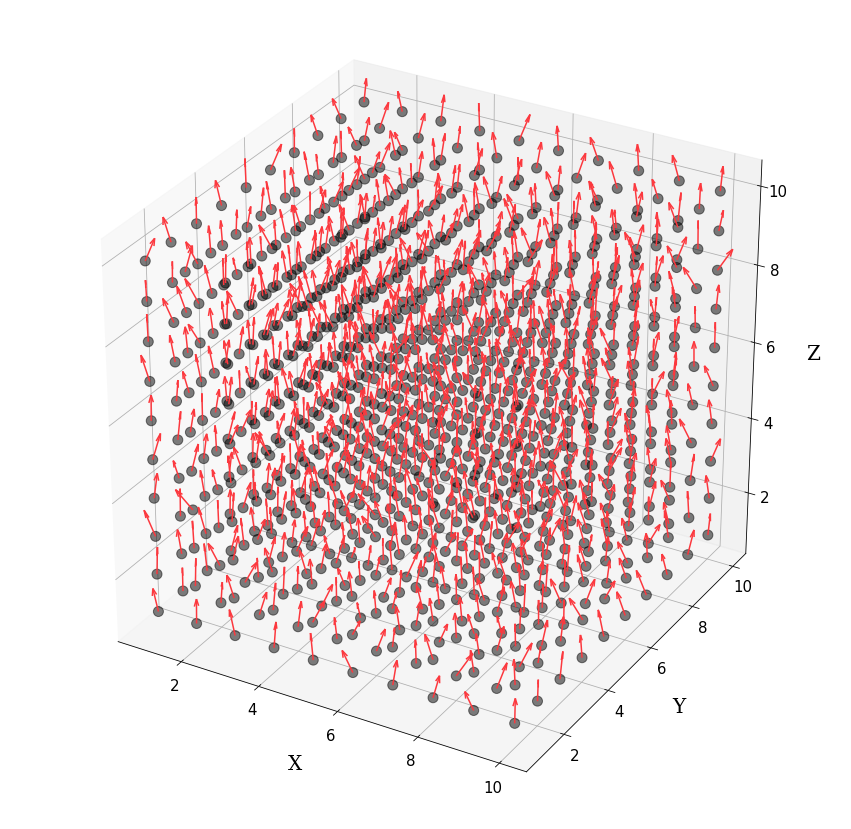

In [14]:
# ============= PLOTTING FINAL CONFIGURATION =============
#Normal 3D plot
%matplotlib inline 
#Interactive 3D plot
#%matplotlib qt 

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfXyz.x, dfXyz.y, dfXyz.z, s=100, alpha=0.5, color="k")
ax.quiver(dfXyz.x, dfXyz.y, dfXyz.z,dfMag.x, dfMag.y, dfMag.z, length=0.65, color='#FC383E')
#ax.set_title('3D - Representation', size="xx-large", family="serif", weight= "semibold")
ax.set_xlabel('X',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.set_ylabel('Y',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.set_zlabel('Z',fontsize= 20, color="#000000", family="serif", labelpad=20)
ax.tick_params(labelsize=15)
plt.savefig('3d.svg')
plt.show()

In [15]:
with open("magData.txt","wb") as file:
    np.savetxt(file,mag,delimiter="\t")